In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import re
from urllib.request import urlopen
from urllib.parse import urlparse
from urllib.error import HTTPError, URLError
from ssl import CertificateError
from socket import timeout as SocketTimeoutError
import sys

In [2]:
from settings import *

## Read Data

In [40]:
def readFromDB(limitDocuments=10):
    
    limitline= 'limit '+str(limitDocuments) if(limitDocuments!=-1) else ''
    
    query = """
    (select id, body, doc_type
    from document
    where doc_type = 'web'
    """+limitline+"""
    )
    UNION
    (select id, body, doc_type
    from document
    where doc_type = 'twitter'
    """+limitline+"""
    ) """

    documents = queryDB(query, 'smeros', '', 'sciArticles')
    documents = documents.set_index('id')
    return documents

In [38]:
def extractLinks(documents):

    urlRegex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    documents['body'] = documents['body'].apply(lambda x: re.findall(urlRegex, x)).to_frame()
    documents.rename(columns={'body': 'urls'}, inplace=True)
    
    return documents

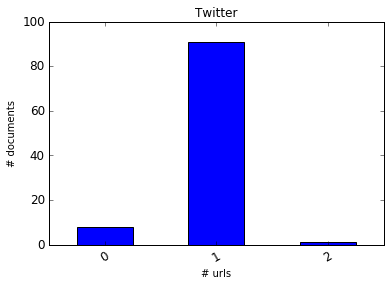

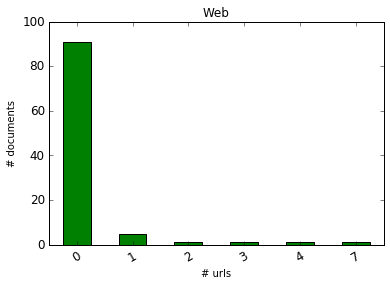

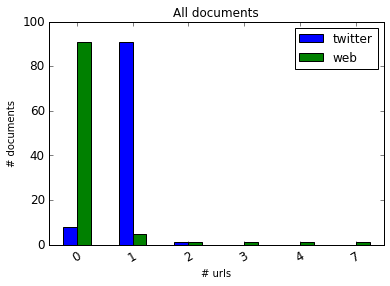

In [45]:
def plotCountLinks(limitDocuments=10):
    
    documents = readFromDB(limitDocuments)
    documents = extractLinks(documents)
    
    #Writes the number of urls per document.
    #If the number is ≥ @linkLimit then instead
    #of the real number, we write "≥ @linkLimit".
    documents['urls'] = documents['urls'].apply(lambda x: len(x) if len(x)<linkLimit else "≥"+str(linkLimit))
    
    #Groups by the doc_type (twitter, web) and the number of urls.
    count =  documents.groupby(['doc_type','urls']).size()
    
    #Reformats the dataframe in order to create the plots.
    docs = {}
    for doc_type in count.index.levels[0]:
        urls=[]
        for urlNum in count.index.levels[1]:
            urls.append(count.get((doc_type, urlNum),0))
        docs[doc_type]=urls

    #Slices the dataframe into 3 views.
    bothCount=pd.DataFrame(docs, index=count.index.levels[1])
    twitterCount=bothCount['twitter'][lambda x: x!=0]
    webCount=bothCount['web'][lambda x: x!=0]
 
    #Creates the 3 plots.
    plt.xticks(rotation=70)
    ax = twitterCount.plot.bar(fontsize=12, color='b', title='Twitter')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel("# urls")
    ax.set_ylabel("# documents")
    plt.show()
    
    ax = webCount.plot.bar(fontsize=12, color='g', title='Web')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel("# urls")
    ax.set_ylabel("# documents")
    plt.show()
    
    ax = bothCount.plot.bar(fontsize=12, color='bg', title='All documents')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel("# urls")
    ax.set_ylabel("# documents")
    plt.show()

plotCountLinks(100)

In [47]:
def flattenLinks(documents):
    
    #Converts pairs of <id, [url1, url2, ...]> to <id, url1>, <id, url2>.
    documents = pd.DataFrame([(row[0], link, row[2]) for row in documents.itertuples() for link in row[1]], columns=['id', 'url', 'doc_type'])
    
    #Removes duplicates.
    if (removeDuplicateLinks):
        documents = documents.drop_duplicates()
        
    return documents

In [48]:
def resolveURLs(documents):

    def resolve(url):
        resolved = {'resolvedURL':'', 'error':'', 'errorDesc':''}
        
        try:
            #Follows the redirections of a url.
            resolvedURL = urlopen(url,timeout=5).geturl()

            #Some *.ly link do not redirect but neither return an error code.
            if(urlparse(resolvedURL).netloc.endswith('.ly')):
                resolved = {'resolvedURL':resolvedURL, 'error':'NoRedirectError', 'errorDesc':''}
            else:
                resolved = {'resolvedURL':resolvedURL, 'error':'NoError', 'errorDesc':''}

        #Catches the different errors.        
        except HTTPError as e:
            resolved = {'resolvedURL':url, 'error':'HTTPError', 'errorDesc':str(e.code)}
        except URLError as e:
            resolved = {'resolvedURL':url, 'error':'URLError', 'errorDesc':str(e)}
        except ConnectionResetError as e:
            resolved = {'resolvedURL':url, 'error':'ConnectionResetError', 'errorDesc':str(e)}
        except CertificateError as e:
            resolved = {'resolvedURL':url, 'error':'CertificateError', 'errorDesc':str(e)}
        except SocketTimeoutError as e:
            resolved = {'resolvedURL':url, 'error':'SocketTimeoutError', 'errorDesc':str(e)}
        except:
            print('!!!!NO CATCH!!!!', sys.exc_info())

        return pd.Series(resolved)
    
    documents = pd.concat((documents, documents['url'].apply(lambda x: resolve(x))), axis=1)
    return documents

ValueError: incomplete format

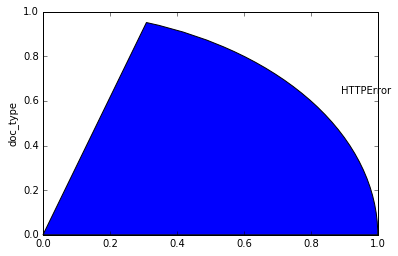

In [63]:
def plotLinkErrors(limitDocuments=10):
    documents = readFromDB(limitDocuments)
    documents = extractLinks(documents)
    documents = flattenLinks(documents)
    documents = resolveURLs(documents)

    documents = documents[['doc_type','error']]
    
    #Groups and counts by error and plots the respective pies.
    twitter = documents[documents['doc_type']=='twitter']
    numOfLinks = twitter.shape[0]
    ax = twitter.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='{%.f}sa\%', title='Link Errors on Twitter')
    ax.set_ylabel('')
    web = documents[documents['doc_type']=='web']
    numOfLinks = web.shape[0]
    ax = web.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%.f', title='Link Errors on Web')
    ax.set_ylabel('')
    numOfLinks = documents.shape[0]
    ax = documents.groupby('error').agg('count').apply(lambda x: x/numOfLinks).plot.pie(y='doc_type', autopct='%.f', title='Link Errors on Both')
    ax.set_ylabel('')
    
plotLinkErrors(10)